In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, accuracy_score
from sklearn.decomposition import PCA

In [ ]:
#Load the dataset
df = pd.read_csv("processed_stroke_dataset.csv")

In [ ]:
#Identifying the true target label which must not be used for K-Means training
#Assuming 'Stroke History' is the binary target (0 or 1)
y_true = df['Stroke History']

In [ ]:
#Features (X) for clustering: Drop the target and 'Diagnosis'
X = df.drop(columns=['Stroke History', 'Diagnosis'])

In [ ]:
print(f"Target distribution ('Stroke History'):\n{y_true.value_counts()}")
print(f"Number of features used for clustering: {X.shape[1]}")
print("-" * 60)

Target distribution ('Stroke History'):
Stroke History
1    7504
0    7496
Name: count, dtype: int64
Number of features used for clustering: 49
------------------------------------------------------------


In [ ]:
#DATA PREPROCESSING (SCALING)
#K-Means is distance-based, so features must be scaled.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#K-MEANS MODEL TRAINING
K = 2 #Fixed K=2 to align with the binary target variable (Stroke/No Stroke)
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)

In [ ]:
#Fit the model to the SCALED features
kmeans.fit(X_scaled)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [ ]:
#Get the cluster assignments (0 or 1)
cluster_labels = kmeans.labels_

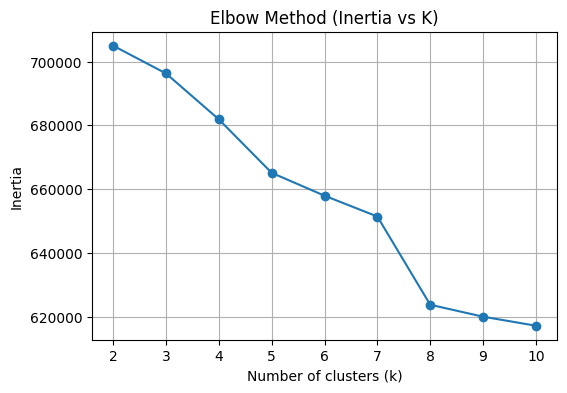

,k,Silhouette,Calinski-Harabasz,Davies-Bouldin
4,6,0.072353,406.486642,3.783856
6,8,0.067713,382.230521,3.195214
5,7,0.059254,378.113913,3.741598
7,9,0.053949,352.390259,3.447326
3,5,0.052189,394.146317,4.182848
8,10,0.050972,324.733581,3.673139
0,2,0.040651,639.055286,4.838439
2,4,0.039470,453.609260,4.264149
1,3,0.033367,530.715744,4.429202


Selected best number of clusters (k): 6


In [25]:
#K-MEANS VARIETY TEST: Compare K=2..10 (Elbow + Metrics)
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#ELBOW METHOD: Find optimal k using inertia
inertias = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method (Inertia vs K)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


results = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    ch  = calinski_harabasz_score(X_scaled, labels)
    db  = davies_bouldin_score(X_scaled, labels)
    results.append({"k": k, "Silhouette": sil, "Calinski-Harabasz": ch, "Davies-Bouldin": db})

cmp_df = pd.DataFrame(results).sort_values(["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"], ascending=[False, False, True])
display(cmp_df)

best_k = int(cmp_df.iloc[0]["k"])
print(f"Selected best number of clusters (k): {best_k}")


In [26]:
#FINAL MODEL USING SELECTED K
final_kmeans = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)
final_labels = final_kmeans.fit_predict(X_scaled)

final_sil = silhouette_score(X_scaled, final_labels)
final_ch  = calinski_harabasz_score(X_scaled, final_labels)
final_db  = davies_bouldin_score(X_scaled, final_labels)

print(f"FINAL MODEL (k={best_k})")
print(f"Silhouette Score       : {final_sil:.4f}")
print(f"Calinski-Harabasz Score: {final_ch:.2f}")
print(f"Davies-Bouldin Score   : {final_db:.4f}")

FINAL MODEL (k=6)
Silhouette Score       : 0.0724
Calinski-Harabasz Score: 406.49
Davies-Bouldin Score   : 3.7839


In [27]:
#EVALUATION: CLUSTER QUALITY & ALIGNMENT
print("--- Evaluation Metrics for K=2 Clustering ---")

#Intrinsic Cluster Quality Metrics (Evaluate separation and density)
silhouette = silhouette_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)

print(f"1. Silhouette Score: {silhouette:.4f} (Closer to 1 is better)")
print(f"2. Calinski-Harabasz Index: {calinski_harabasz:.4f} (Higher is better)")

--- Evaluation Metrics for K=2 Clustering ---
1. Silhouette Score: 0.0407 (Closer to 1 is better)
2. Calinski-Harabasz Index: 639.0553 (Higher is better)


In [28]:
#Alignment Accuracy (Compare arbitrary cluster labels to true labels)
#K-Means labels (0 and 1) might be reversed relative to the true labels, so we check both possible mappings.
acc_direct = accuracy_score(y_true, cluster_labels)
acc_inverted = accuracy_score(y_true, 1 - cluster_labels) # 1 - label flips 0s and 1s

best_accuracy = max(acc_direct, acc_inverted)

print(f"3. Alignment Accuracy (Best Match to True Labels): {best_accuracy:.4f}")

3. Alignment Accuracy (Best Match to True Labels): 0.5006


In [31]:
#VISUALIZATION
#Reduce the high-dimensional data to 2 components for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

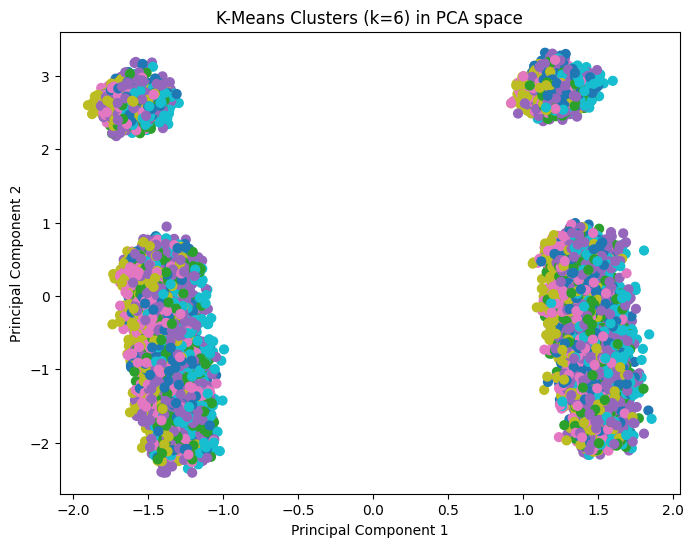

In [32]:
#FINAL VISUALIZATION (PCA Scatter)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=final_labels, cmap='tab10', s=40)
plt.title(f"K-Means Clusters (k={best_k}) in PCA space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

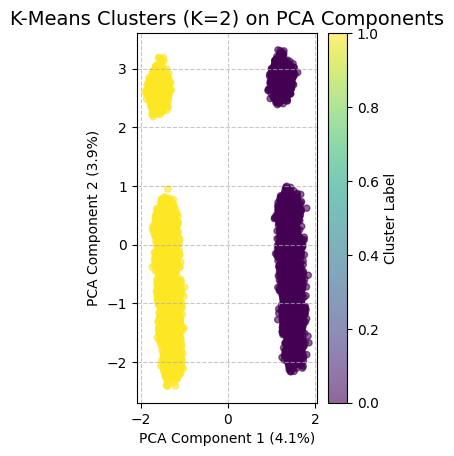

In [33]:
#K-Means Clusters
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=20, alpha=0.6)
plt.title(f'K-Means Clusters (K={K}) on PCA Components', fontsize=14)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.colorbar(scatter1, label='Cluster Label')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

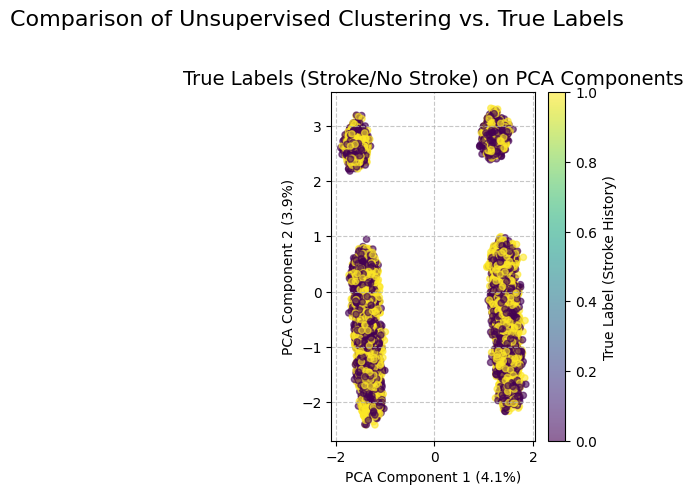

Visualization saved as 'kmeans_pca_comparison.png'


In [34]:
#Plotting True Labels
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', s=20, alpha=0.6)
plt.title('True Labels (Stroke/No Stroke) on PCA Components', fontsize=14)
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.colorbar(scatter2, label='True Label (Stroke History)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.suptitle("Comparison of Unsupervised Clustering vs. True Labels", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('kmeans_pca_comparison.png')
plt.close()

print("Visualization saved as 'kmeans_pca_comparison.png'")